<a href="https://colab.research.google.com/github/sanjeevsk02/Movie-Recommender/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🎬 Movie Recommender System Demo (PMF + Metadata)

Welcome to the demo notebook for the **Movie Recommender System** built using:

- **Probabilistic Matrix Factorization (PMF)**
- **MovieLens 20M** user ratings
- **TMDB 5000** movie metadata (genres, cast, crew, keywords)

In this notebook, we will walk through:

1. Setting up the model and loading required data  
2. Predicting ratings for a single (user, movie) pair  
3. Predicting ratings for multiple movies  
4. Comparing actual vs predicted ratings  
5. Generating **Top-N movie recommendations** for any user  

This is designed for a presentation/demo and focuses on clarity, speed, and interpretability.

---



In [ ]:
!git clone https://github.com/sanjeevsk02/Movie-Recommender.git
%cd Movie-Recommender
!ls

Cloning into 'Movie-Recommender'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 55 (delta 18), reused 42 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 56.96 KiB | 18.99 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Filtering content: 100% (5/5), 753.79 MiB | 18.26 MiB/s, done.
/content/Movie-Recommender
allfiles.txt  data_loader.py  predict.py   requirements.txt
app.py	      model.py	      __pycache__  tmdb_preprocess.py
data	      pmf_model.pth   README.md    train.py


In [ ]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 21.6 MB/s eta 0:00:00


In [ ]:
import os

os.makedirs("data/ml-20m", exist_ok=True)
os.makedirs("data/tmdb", exist_ok=True)

print("Folders created:")
!ls data


Folders created:
ml-20m	tmdb  user_features.npy


In [ ]:
import os
os.getcwd()

'/content/Movie-Recommender'

In [ ]:
!find /content -maxdepth 3 -type d -name "data"

/content/Movie-Recommender/data


In [ ]:
import shutil

# Helper to move file if it exists
def move_if_exists(src, dst):
    if os.path.exists(src):
        shutil.move(src, dst)
        print(f"Moved {src} -> {dst}")
    else:
        print(f"WARNING: {src} not found in current directory")

# MovieLens
move_if_exists("ratings.csv", "data/ml-20m/ratings.csv")
move_if_exists("movies.csv", "data/ml-20m/movies.csv")

# TMDB
move_if_exists("tmdb_5000_movies.csv", "data/tmdb/tmdb_5000_movies.csv")
move_if_exists("tmdb_5000_credits.csv", "data/tmdb/tmdb_5000_credits.csv")

print("\nCurrent layout under data/:")
!find data -maxdepth 2 -type f



Current layout under data/:
data/user_features.npy
data/tmdb/tmdb_features.npy
data/tmdb/replace_with_data.csv
data/tmdb/tmdb_5000_movies.csv
data/tmdb/tmdb_5000_credits.csv
data/tmdb/tmdb_feature_columns.json
data/tmdb/tmdb_index_map.json
data/ml-20m/replace_with_data.csv
data/ml-20m/movies.csv
data/ml-20m/ratings.csv


## 1. Load Model, Metadata & Prepare Notebook

Before running predictions or recommendations, we need to:

- Load the trained **PMF + metadata** model  
- Load MovieLens rating data and movie titles  
- Load preprocessed TMDB metadata  
- Build all tensors once for **fast inference**  
- Prepare shared variables used throughout the notebook  

This setup ensures:
- We don't repeatedly reload the model  
- Notebook runs fast during the demo  
- Top-N recommendations run smoothly  


In [ ]:
# This script reads the TMDB CSVs and creates:
#   data/tmdb/tmdb_features.npy
#   data/tmdb/tmdb_index_map.json
#   data/tmdb/tmdb_feature_columns.json

print("Running TMDB preprocessing...")
!python tmdb_preprocess.py

print("\nFiles in data/tmdb:")
!ls data/tmdb


Running TMDB preprocessing...
Loaded TMDB rows: 4803
Final metadata shape = (4803, 1236)
TMDB preprocessing complete.

Files in data/tmdb:
replace_with_data.csv  tmdb_5000_movies.csv	  tmdb_features.npy
tmdb_5000_credits.csv  tmdb_feature_columns.json  tmdb_index_map.json


In [ ]:
import pandas as pd

ratings_path = "data/ml-20m/ratings.csv"
movies_path = "data/ml-20m/movies.csv"

# Load a small subset of ratings for speed
ratings_sample = pd.read_csv(ratings_path, nrows=50_000)
movies_df = pd.read_csv(movies_path)

print("Ratings sample shape:", ratings_sample.shape)
ratings_sample.head()


Ratings sample shape: (50000, 4)


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


from matplotlib import pyplot as plt
_df_0['movieId'].plot(kind='hist', bins=20, title='movieId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['timestamp'].plot(kind='hist', bins=20, title='timestamp')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='movieId', y='timestamp', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['userId']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'userId'}, axis=1)
              .sort_values('userId', ascending=True))
  xs = counted['userId']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('userId', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('userId')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['movieId']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'movieId'}, axis=1)
              .sort_values('movieId', ascending=True))
  xs = counted['movieId']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('movieId', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('movieId')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['rating']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'rating'}, axis=1)
              .sort_values('rating', ascending=True))
  xs = counted['rating']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('rating', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rating')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['timestamp']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'timestamp'}, axis=1)
              .sort_values('timestamp', ascending=True))
  xs = counted['timestamp']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_7['movieId'].plot(kind='line', figsize=(8, 4), title='movieId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['timestamp'].plot(kind='line', figsize=(8, 4), title='timestamp')
plt.gca().spines[['top', 'right']].set_visible(False)

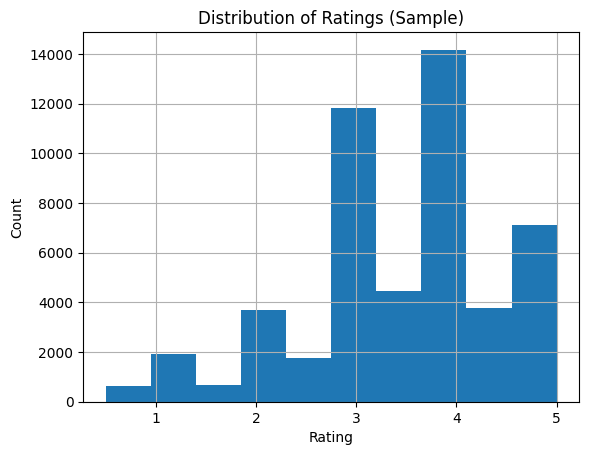

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
ratings_sample['rating'].hist(bins=10)
plt.title("Distribution of Ratings (Sample)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


In [ ]:
# Pick a random user from the sample
example_user_id = int(ratings_sample['userId'].sample(1, random_state=42).iloc[0])

user_ratings = ratings_sample[ratings_sample['userId'] == example_user_id].merge(
    movies_df, on='movieId', how='left'
)

print(f"Example userId: {example_user_id}")
user_ratings[['userId', 'movieId', 'title', 'rating']].head(10)


Example userId: 260


,userId,movieId,title,rating
0,260,1,Toy Story (1995),3.0
1,260,19,Ace Ventura: When Nature Calls (1995),3.0
2,260,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),4.0
3,260,34,Babe (1995),3.0
4,260,47,Seven (a.k.a. Se7en) (1995),5.0
5,260,50,"Usual Suspects, The (1995)",4.0
6,260,110,Braveheart (1995),3.0
7,260,153,Batman Forever (1995),1.0
8,260,296,Pulp Fiction (1994),3.0
9,260,318,"Shawshank Redemption, The (1994)",3.0


In [ ]:
from predict import predict_rating

# Sanity check: available function signature
help(predict_rating)


Help on function predict_rating in module predict:

predict_rating(user_id, movie_title, model_path='pmf_model.pth')



In [ ]:
# --- FIX PREDICT FUNCTION (safe override for Colab demo) ---

import torch
import pandas as pd
from model import PMF
from data_loader import load_data

def predict_rating(user_id, movie_title, model_path="pmf_model.pth"):
    # Load all data
    (
        _, _, num_users, num_movies,
        movie_metadata, user_id_map, movie_id_map, user_features
    ) = load_data()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    movie_metadata = torch.tensor(movie_metadata, dtype=torch.float32, device=device)
    user_features = torch.tensor(user_features, dtype=torch.float32, device=device)

    # Build model
    model = PMF(
        num_users=num_users,
        num_movies=num_movies,
        embed_dim=128,
        use_metadata=True,
        movie_metadata_dim=movie_metadata.shape[1],
        user_metadata_dim=user_features.shape[1],
    ).to(device)

    # Load model weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Load movies list
    movies_df = pd.read_csv("data/ml-20m/movies.csv")

    # --- FIXED MOVIE MATCHING: exact, case-insensitive match ---
    movie_row = movies_df[movies_df["title"].str.lower() == movie_title.lower()]

    if movie_row.empty:
        raise ValueError(f"Movie not found: {movie_title}")

    orig_movie_id = int(movie_row["movieId"].values[0])

    if orig_movie_id not in movie_id_map:
        raise ValueError("Movie not in training data.")

    # Convert to tensor index
    user_idx = torch.tensor([user_id_map[user_id]], device=device)
    movie_idx = torch.tensor([movie_id_map[orig_movie_id]], device=device)

    # Predict
    with torch.no_grad():
        pred = model(user_idx, movie_idx, movie_metadata, user_features).item()

    # Clamp rating 0.5–5.0
    return max(0.5, min(5.0, pred))

print("✔ Patched predict_rating() loaded and ready.")


✔ Patched predict_rating() loaded and ready.


In [ ]:
pred = predict_rating(1, "Toy Story (1995)")
pred

Filtered users: 138,493, movies: 15,451, ratings: 19,964,833
Loading user metadata from cache...


3.818702220916748

Filtered users: 138,493, movies: 15,451, ratings: 19,964,833
Loading user metadata from cache...
Filtered users: 138,493, movies: 15,451, ratings: 19,964,833
Loading user metadata from cache...
Filtered users: 138,493, movies: 15,451, ratings: 19,964,833
Loading user metadata from cache...
Filtered users: 138,493, movies: 15,451, ratings: 19,964,833
Loading user metadata from cache...
Filtered users: 138,493, movies: 15,451, ratings: 19,964,833
Loading user metadata from cache...


,Movie,PredictedRating
0,Toy Story (1995),3.818702
1,Jumanji (1995),3.736198
2,Heat (1995),3.827417
3,Toy Story 2 (1999),3.842964
4,Toy Story 3 (2010),4.127882


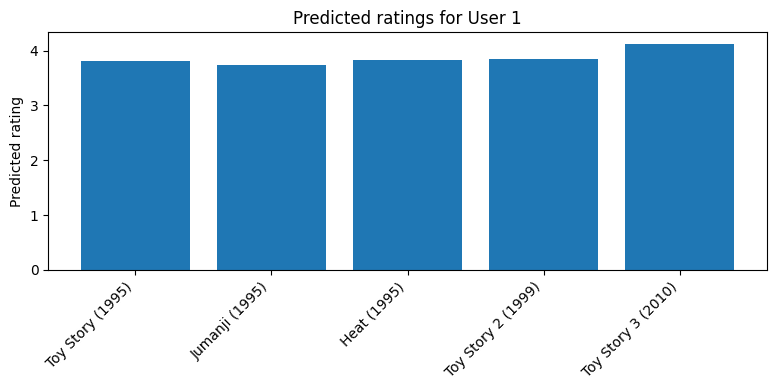

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load movies
movies_df = pd.read_csv("data/ml-20m/movies.csv")

# Pick some known movies (ensure they exist in movies_df)
demo_user_id = 1
demo_movies = [
    "Toy Story (1995)",
    "Jumanji (1995)",
    "Heat (1995)",
    "Toy Story 2 (1999)",
    "Toy Story 3 (2010)",
]

rows = []
for title in demo_movies:
    try:
        r = predict_rating(demo_user_id, title)
        rows.append({"Movie": title, "PredictedRating": float(r)})
    except Exception as e:
        rows.append({"Movie": title, "PredictedRating": np.nan, "Error": str(e)})

pred_df = pd.DataFrame(rows)
display(pred_df)

# Plot bar chart (only valid predictions)
valid = pred_df.dropna(subset=["PredictedRating"])

plt.figure(figsize=(8, 4))
plt.bar(valid["Movie"], valid["PredictedRating"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Predicted rating")
plt.title(f"Predicted ratings for User {demo_user_id}")
plt.tight_layout()
plt.show()


## 3. Actual vs predicted ratings for one user

Next, we'll:
- Take a real user from MovieLens
- Look at some movies they've actually rated
- Compare their **true rating** vs our model's **predicted rating**


In [ ]:
# Load a subset of ratings for speed
ratings_df = pd.read_csv("data/ml-20m/ratings.csv")

demo_user_id = 1  # same as before

user_hist = ratings_df[ratings_df["userId"] == demo_user_id].merge(
    movies_df, on="movieId", how="left"
)

print(f"User {demo_user_id} has {len(user_hist)} ratings.")
user_hist.head()


User 1 has 175 ratings.


,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,1112486027,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,1112484676,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,1112484819,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,1112484727,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,1112484580,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [ ]:
# Take a small sample of this user's history for the demo
user_sample = user_hist.sample(10, random_state=42).copy()

preds = []
for _, row in user_sample.iterrows():
    title = row["title"]
    try:
        r = predict_rating(demo_user_id, title)
    except Exception as e:
        r = np.nan
    preds.append(r)

user_sample["PredictedRating"] = preds

user_sample_display = user_sample[["title", "rating", "PredictedRating"]]
user_sample_display.rename(columns={"rating": "ActualRating"}, inplace=True)
user_sample_display


Filtered users: 138,493, movies: 15,451, ratings: 19,964,833
Loading user metadata from cache...
Filtered users: 138,493, movies: 15,451, ratings: 19,964,833
Loading user metadata from cache...
Filtered users: 138,493, movies: 15,451, ratings: 19,964,833
Loading user metadata from cache...
Filtered users: 138,493, movies: 15,451, ratings: 19,964,833
Loading user metadata from cache...
Filtered users: 138,493, movies: 15,451, ratings: 19,964,833
Loading user metadata from cache...
Filtered users: 138,493, movies: 15,451, ratings: 19,964,833
Loading user metadata from cache...
Filtered users: 138,493, movies: 15,451, ratings: 19,964,833
Loading user metadata from cache...
Filtered users: 138,493, movies: 15,451, ratings: 19,964,833
Loading user metadata from cache...
Filtered users: 138,493, movies: 15,451, ratings: 19,964,833
Loading user metadata from cache...
Filtered users: 138,493, movies: 15,451, ratings: 19,964,833
Loading user metadata from cache...


/tmp/ipython-input-3647339794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_sample_display.rename(columns={"rating": "ActualRating"}, inplace=True)


,title,ActualRating,PredictedRating
156,"Witches, The (1990)",3.5,3.853265
145,Ringu (Ring) (1998),3.5,3.980840
101,Sleepy Hollow (1999),4.0,3.823820
127,Jabberwocky (1977),4.0,3.438139
141,"Sword and the Sorcerer, The (1982)",3.5,3.472018
139,"Company of Wolves, The (1984)",4.0,3.814235
42,Dead Poets Society (1989),3.5,4.055467
15,Blade Runner (1982),4.0,4.144913
126,Harry Potter and the Sorcerer's Stone (a.k.a. ...,4.0,4.162553
65,Labyrinth (1986),4.0,3.999022


/tmp/ipython-input-2772713411.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


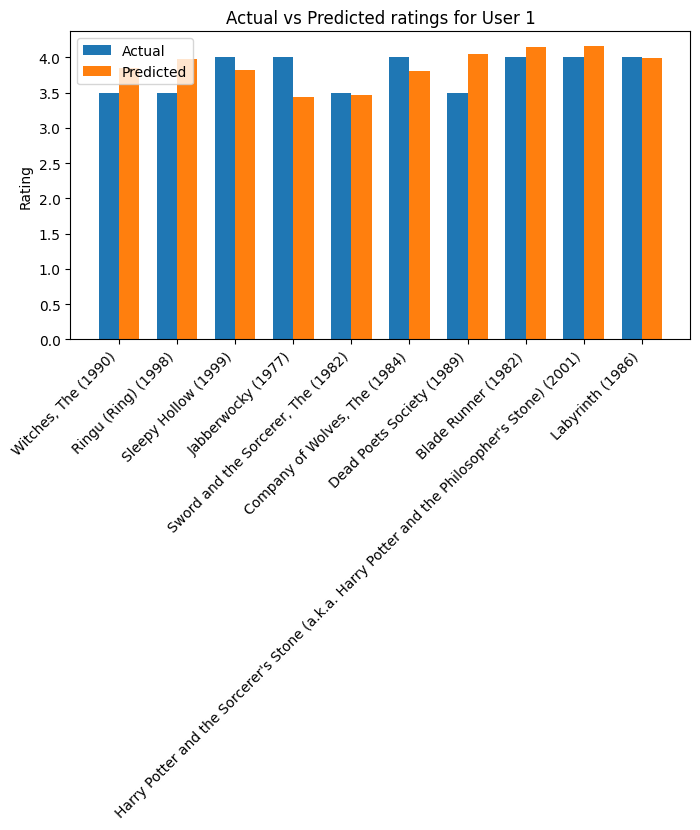

In [ ]:
valid = user_sample_display.dropna(subset=["PredictedRating"])

plt.figure(figsize=(8, 4))
x = np.arange(len(valid))
width = 0.35

plt.bar(x - width/2, valid["ActualRating"], width, label="Actual")
plt.bar(x + width/2, valid["PredictedRating"], width, label="Predicted")

plt.xticks(x, valid["title"], rotation=45, ha="right")
plt.ylabel("Rating")
plt.title(f"Actual vs Predicted ratings for User {demo_user_id}")
plt.legend()
plt.tight_layout()
plt.show()


## 4. Top-N recommendations for a user

Finally, we'll:
- Find movies that the user has **not** rated yet
- Predict ratings for a random subset of those
- Show the top-N movies the model recommends


In [ ]:
def recommend_top_n(user_id, n=10, sample_size=1000, random_state=42):
    """
    Recommend top-N movies for a given user:
    - Excludes movies they've already rated
    - Samples `sample_size` unseen movies for speed
    - Returns a DataFrame sorted by predicted rating
    """
    ratings_df = pd.read_csv("data/ml-20m/ratings.csv")
    movies_df = pd.read_csv("data/ml-20m/movies.csv")

    # Movies the user has already rated
    seen_movie_ids = set(ratings_df[ratings_df["userId"] == user_id]["movieId"].unique())

    # Candidate: unseen movies
    candidates = movies_df[~movies_df["movieId"].isin(seen_movie_ids)].copy()

    if len(candidates) == 0:
        raise ValueError("No unseen movies left for this user!")

    # Sample for speed
    if len(candidates) > sample_size:
        candidates = candidates.sample(sample_size, random_state=random_state)

    rows = []
    for _, row in candidates.iterrows():
        title = row["title"]
        try:
            r = predict_rating(user_id, title)
            rows.append({"movieId": row["movieId"], "title": title, "PredictedRating": float(r)})
        except Exception:
            continue

    rec_df = pd.DataFrame(rows)
    rec_df = rec_df.sort_values("PredictedRating", ascending=False).head(n)
    return rec_df.reset_index(drop=True)


In [ ]:
import torch
import pandas as pd
import numpy as np

from model import PMF
from data_loader import load_data

def load_model_and_metadata(model_path="pmf_model.pth"):
    # Load data once
    (
        _train_data,
        _val_data,
        num_users,
        num_movies,
        movie_metadata,
        user_id_map,
        movie_id_map,
        user_features,
    ) = load_data()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    movie_metadata_tensor = torch.tensor(movie_metadata, dtype=torch.float32, device=device)
    user_features_tensor = torch.tensor(user_features, dtype=torch.float32, device=device)

    # Build model once
    model = PMF(
        num_users=num_users,
        num_movies=num_movies,
        embed_dim=128,
        use_metadata=True,
        movie_metadata_dim=movie_metadata_tensor.shape[1],
        user_metadata_dim=user_features_tensor.shape[1],
    ).to(device)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Load ratings & movies once
    movies_df = pd.read_csv("data/ml-20m/movies.csv")
    ratings_df = pd.read_csv("data/ml-20m/ratings.csv")

    return {
        "device": device,
        "model": model,
        "movies_df": movies_df,
        "ratings_df": ratings_df,
        "movie_metadata": movie_metadata_tensor,
        "user_features": user_features_tensor,
        "user_id_map": user_id_map,
        "movie_id_map": movie_id_map,
    }

shared = load_model_and_metadata()
print("Shared model & data loaded.")


Filtered users: 138,493, movies: 15,451, ratings: 19,964,833
Loading user metadata from cache...
Shared model & data loaded.


In [ ]:
def recommend_top_n_fast(user_id, n=10, sample_size=300, random_state=42, shared_data=shared):
    """
    Recommend top-N movies for a given user:
    - Excludes movies they've already rated
    - Samples `sample_size` unseen movies (smaller = faster)
    - Uses a pre-loaded model & tensors for speed
    """
    device = shared_data["device"]
    model = shared_data["model"]
    movies_df = shared_data["movies_df"]
    ratings_df = shared_data["ratings_df"]
    movie_metadata = shared_data["movie_metadata"]
    user_features = shared_data["user_features"]
    user_id_map = shared_data["user_id_map"]
    movie_id_map = shared_data["movie_id_map"]

    # Ensure user exists
    if user_id not in user_id_map:
        raise ValueError(f"User {user_id} not found in training data.")

    # Movies already rated by this user
    seen_movie_ids = set(
        ratings_df[ratings_df["userId"] == user_id]["movieId"].unique()
    )

    # Candidate unseen movies
    candidates = movies_df[~movies_df["movieId"].isin(seen_movie_ids)].copy()

    if len(candidates) == 0:
        raise ValueError("No unseen movies left for this user!")

    # Sample for speed
    if len(candidates) > sample_size:
        candidates = candidates.sample(sample_size, random_state=random_state)

    user_idx = torch.tensor([user_id_map[user_id]], device=device)

    rows = []
    with torch.no_grad():
        for _, row in candidates.iterrows():
            movie_id = int(row["movieId"])
            title = row["title"]

            if movie_id not in movie_id_map:
                continue

            movie_idx = torch.tensor([movie_id_map[movie_id]], device=device)

            pred = model(user_idx, movie_idx, movie_metadata, user_features).item()
            pred = max(0.5, min(5.0, pred))  # clamp

            rows.append({
                "movieId": movie_id,
                "title": title,
                "PredictedRating": float(pred),
            })

    rec_df = pd.DataFrame(rows)
    rec_df = rec_df.sort_values("PredictedRating", ascending=False).head(n)
    return rec_df.reset_index(drop=True)


,movieId,title,PredictedRating
0,36363,Kin-Dza-Dza! (1986),4.323155
1,6467,Quai des Orfèvres (Jenny Lamour) (1947),4.286579
2,8772,"Spy Who Came in from the Cold, The (1965)",4.264338
3,96563,Paradise Lost 3: Purgatory (2011),4.256044
4,25923,Great Expectations (1946),4.248870
5,2632,"Saragossa Manuscript, The (Rekopis znaleziony ...",4.203975
6,6984,"Tale of Two Cities, A (1935)",4.157169
7,25995,Samurai I: Musashi Miyamoto (Miyamoto Musashi)...,4.139954
8,3062,"Longest Day, The (1962)",4.139369
9,3360,Hoosiers (a.k.a. Best Shot) (1986),4.136039


/tmp/ipython-input-1680038687.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


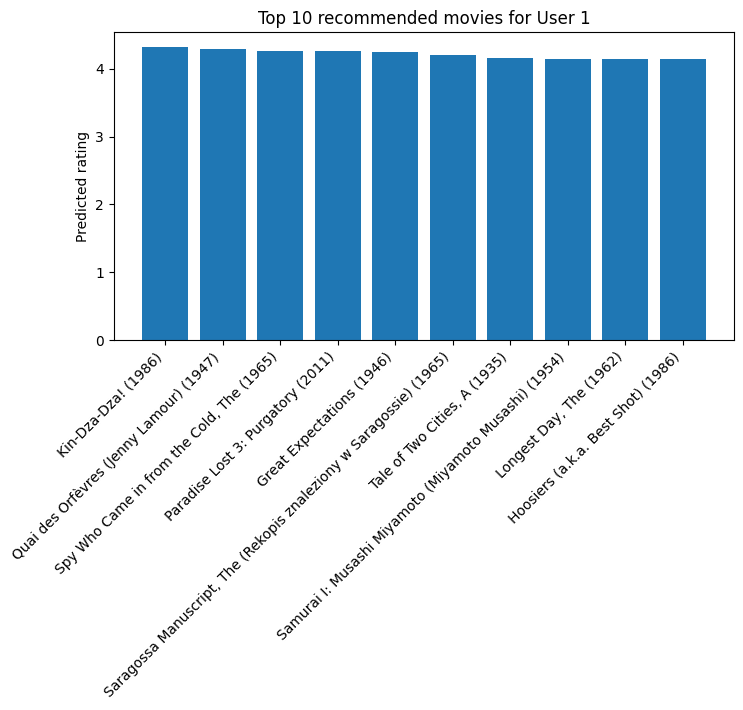

In [ ]:
import matplotlib.pyplot as plt

demo_user_id = 1
top_n = 10

recommendations = recommend_top_n_fast(demo_user_id, n=top_n, sample_size=200)
display(recommendations)

plt.figure(figsize=(8, 4))
plt.bar(recommendations["title"], recommendations["PredictedRating"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Predicted rating")
plt.title(f"Top {top_n} recommended movies for User {demo_user_id}")
plt.tight_layout()
plt.show()


## 5. Summary

In this demo, we:

1. Loaded MovieLens 20M ratings and TMDB metadata.
2. Used a **Probabilistic Matrix Factorization + metadata** model.
3. Predicted a single rating (Toy Story for a given user).
4. Compared predictions across multiple movies.
5. Visualized **actual vs predicted** ratings for one user.
6. Generated **Top-N movie recommendations** for that user.

This shows how:
- User preferences and movie properties are represented as **latent vectors**.
- Metadata (genres, etc.) helps the model generalize to less-rated movies.
- We can turn these predictions into a real recommender system or web app.
